# Scania APS Sensor Failure Prediction

## 1) Problem Statement

### Data: Sensor Data

### Problem Statement:

- The system in focus is the Air Pressure System (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failure for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repais. So it is required to minimize the false predictions.

| True Class    | Positive    | Negative    |
|---------------|-------------|-------------|
|<b>Predicted class</b>|      |             |
| Positive      | -           | cost_1      |
| Negative      | cost_2      | -           |

cost_1 = 10
cost_2 = 500

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty truck, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

## Challenges and other objectives

- Need to handle many null values in almost all columns
- No low-latency requirement
- Interpretability is not important
- Misclassification leads to unncessary repair cost

In [41]:
### Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


### Read Data

In [42]:
df = pd.read_csv('aps_failure_training_set.csv', na_values = 'na')

In [43]:
# check top 5 rows
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [44]:
# check number of rows and columns
df.shape

(36188, 171)

In [45]:
# check unique values of target variable
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [46]:
# define numerical and categorical features
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print features
print(' we have {} numerical features: {}'.format(len(numerical_features),numerical_features))
print(' we have {} categorical features: {}'.format(len(categorical_features),categorical_features))

 we have 170 numerical features: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

### Checking missing values

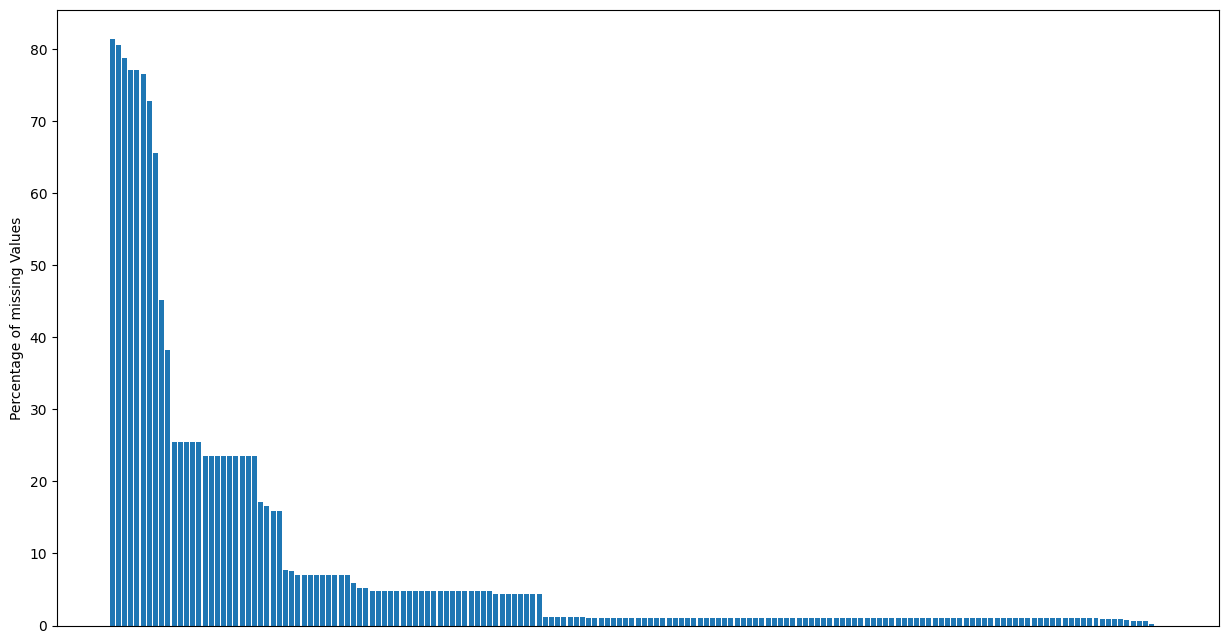

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)
ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel('Percentage of missing Values')
plt.show()


- Dropping columns which has more than 70% missing values

In [48]:
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [49]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [50]:
# check shape of dataset after dropping columns
df.shape

(36188, 164)

#### check total percentage of missing values of full dataset after dropping columns with more than 70% of missing values

In [51]:
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()
total_cells = np.product(df.shape)

print(f'Percentage of total missing cells in the data {(total_missing/total_cells)*100}')

Percentage of total missing cells in the data 5.37059852747306


### Visualization of Unique values in Target variable

In [52]:
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='count'>

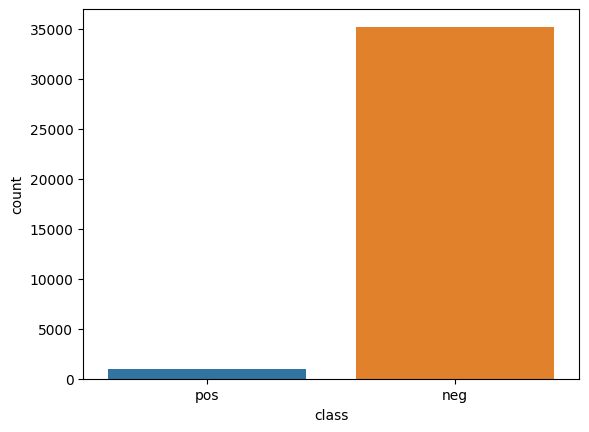

In [53]:
sns.countplot(df,x='class')

#### Report

- target classes are highly imbalanced
- class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e no. of datapoints in the negative class (mojority class) very large compared to that of the positive class(minority class)
- if imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model
- hence, we should handle imbalanced data with certain methods

#### How to handle imbalanced data?

- Resampling data is one of the most common way to deal with imbalanced data. There are two types of resampling - Undersampling ad Oversampling
- In most cases, oversampling is preffered over undersampling techniques. In undersampling we tend to remove instances from data that may be carrying some important information 
- SMOTE ( Synthetic Minority Oversampling Technique): It is oversampling technique where synthetic samples are generated for minority class
- Hybridization techniques invlove combining both oversampling and undersampling techniques. This is done to optimize performance of the classifier models for samples created as part of these techniques.
- It only duplicates the data and it wont add new information.

### Create functions for model training and evaluation

In [54]:
def evaluate_clf(true, predicted):
    '''
    This function takes the true and predicted values
    Returns: Accuracy, F1 Score, Precision, Recall, Roc-Auc-Score
    '''
    acc = accuracy_score(true, predicted) # calculate accuracy
    f1 = f1_score(true, predicted) # calculate f1
    precision = precision_score(true, predicted) # calculate precision
    recall = recall_score(true,predicted) # calculate recall
    roc_auc = roc_auc_score(true, predicted) # calculate roc_auc_score
    return acc, f1, precision, recall, roc_auc

In [55]:
# Create cost of the model as per data description
def total_cost(y_true,y_pred):
    '''
    This function takes y_true and y_predicted values and prints total cost due to misclassification
    '''
    tn,fp,fn,tn =  confusion_matrix(y_true, y_pred).ravel()
    cost = 10 * fp + 500 * fn
    return cost

In [81]:
# create function to evaluate model and return a report
def evaluate_models(X,y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits data into training and testing sets
    Iterates through given model dictionary and evaluates metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # train model

        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)
        
        # test set performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model Performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 Score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- ROC AUC Score: {:.4f}".format(model_train_rocauc_score))
        print('- Cost: {}'.format(train_cost))

        print("--------------------------------")

        print('Model Performance for Testing set')
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print("- F1 Score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- ROC AUC Score: {:.4f}".format(model_test_rocauc_score))
        print('- Cost: {}'.format(test_cost))
        cost_list.append(test_cost)
        print('='*35)
        print('\n')

    report = pd.DataFrame(list(zip(models_list, cost_list, accuracy_list)), columns=['Model Name','Cost','Accuracy']).sort_values(by='Cost')
    return report


### Plot distribution of all independent numeric features

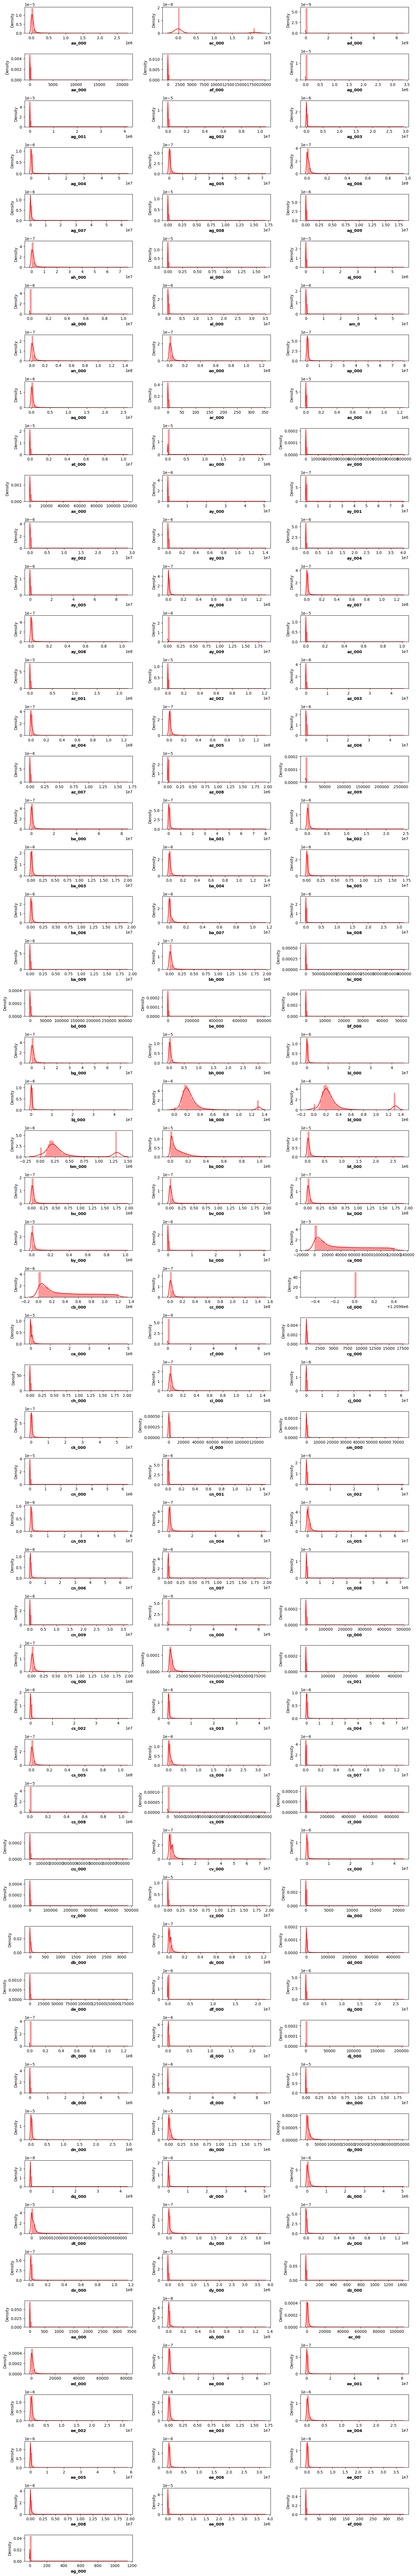

In [62]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
plt.figure(figsize=(15,100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='red')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

- most of the features are not normally distributed
- transformation of data is not of prime importance since it is a classification problem
- interpreting each and every column is not necessary as this is sensor data

## Evaluate model on different experiments

In [63]:
# Spliting Independent feature X and Target feature y 
X = df.drop('class', axis=1)
y = df['class']

#### Manually Encoding target variable

In [65]:
y = y.replace({'pos':1,'neg':0})

### Experiment 1: KNN Imputer for null values

##### Why RobustScaler and not StandardScaler?
- Scaling the data using RobustScaler
- Since most of the independent variables are not normally distributed we cannot use standard scaler

##### Why RobustScaler and MinMaxScaler? *
- because most features has outliers. so MinMax will scale data according to Max values which is outlier.
- This scaler removes the median and scales the data according to the quantile range (defauls to IQR: Interquartile range)
- IQR is range between 1 st Quartile and 3 rd Quartile

In [67]:
# Fit with Robust Scaler for KNN best K selection experiment
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

### Why KNN Imputer?

- KNN Imputer by scikit learn is widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNN Imputer helps to impute missing values present in the observations by finding the nearest neighbors with Euclidean distance matrix.
- Here we iterates through different K values and get accuracy and choose best K values

### Finding optimal n_neighbor value for KNN imputer

In [69]:
results = []
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))),('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print(f'n_neighbors = {s} | accuracy = {mean(scores)})')

n_neighbors = 1 | accuracy = 0.7500552669393169)
n_neighbors = 3 | accuracy = 0.7146291588371836)
n_neighbors = 5 | accuracy = 0.7186636454073173)
n_neighbors = 7 | accuracy = 0.7118381784016801)
n_neighbors = 9 | accuracy = 0.7211782911462363)


- We can observe n_neighbors = 1 able to produce highest accuracy

In [73]:
#### Pipeline for KNN Imputer

In [74]:
num_features = X.select_dtypes(exclude='object').columns

# fit KNN Imputer with selected K value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=1)),
    ('RobustScaler', RobustScaler())
])

In [75]:
X_knn = knn_pipeline.fit_transform(X)

#### Handling Imbalanced Data

*Smote Tomek* is one of such hybrid technique that aims to clean overlapping data points for each classes distributed in sample space.

- This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove data that are identified as Tomek links from majority class.

- To add new data of minority class

1. Choose random data from minority class
2. Calculate distance between random data and its k nearest neighbors
3. Multiply difference with random number between 0 and 1, then add result to minority class as synthetic sample
4. Repeat step number 2-3 until desired proportion of minority class is met

- To remove the tomek links of majority class
1. Choose random data from majority class
2. If random data's nearest neighbor is the data from minority class (i.e create Tomek Link) then remove the Tomek link

- This method instead of adding duplicate data it synthesises the new data based on already available classes. Hence we choose this as our imputer method for this problem.

In [77]:
from imblearn.combine import SMOTETomek

# Resampling minority class. strategy can be changed as required.
smt = SMOTETomek(random_state = 42, sampling_strategy='minority', n_jobs = -1)

# Fit the model to generate data
X_res, y_res = smt.fit_resample(X_knn, y)

In [78]:
### Initialize Default Models in Dictionary

# Dictionary which contains models for experiment
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoosting': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Support Vector Classifier': SVC(),
    'K- Neighbors Classifier': KNeighborsClassifier(),
    'XGBoost Classifier': XGBClassifier(),
    'Catboost Classifier': CatBoostClassifier(verbose=False)
}

#### Fit KNN Imputed Data for models in dictionary

In [82]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
- Cost: 0
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9916
- F1 Score: 0.9917
- Precision: 0.9875
- Recall: 0.9959
- ROC AUC Score: 0.9916
- Cost: 15390


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9838
- F1 Score: 0.9838
- Precision: 0.9814
- Recall: 0.9862
- ROC AUC Score: 0.9838
- Cost: 198730
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9819
- F1 Score: 0.9821
- Precision: 0.9790
- Recall: 0.9851
- ROC AUC Score: 0.9819
- Cost: 53990


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9750
- F1 Score: 0.9749
- Precision: 0.9756
- Recall: 0.9743
- ROC AUC Score: 0.9750
- Cost: 367320
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9761
- F1 Score: 0.9763
- Precision: 0.9748
- Recall: 0.9779
- ROC AU

#### Report for KNN Imputed Data

In [83]:
report_knn

,Model Name,Cost,Accuracy
7,XGBoost Classifier,4430,0.996364
8,Catboost Classifier,7030,0.995295
0,Random Forest,15390,0.991588
4,Decision Tree Classifier,39250,0.985672
6,K- Neighbors Classifier,49860,0.972911
1,Gradient Boosting,53990,0.981893
2,AdaBoosting,79790,0.976119
3,Logistic Regression,322780,0.588751
5,Support Vector Classifier,1648400,0.755204


- for the experiment 1: KNN Imputer has XGBoost classifier as the best model

### Experiment 2: Simple Imputer with Strategy Median

- SimpleImputer is a class in sklearn.impute module that can be used to replace missing value in dataset using variety of input strategies
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. Simple Imputer will then replace missing values in all of the specified columns

In [84]:
num_features = X.select_dtypes(exclude="object").columns

# Fit simple imputer with strategy median
median_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="median")),
    ('Robust Scaler', RobustScaler())
])

In [85]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [86]:
# Resampling minority class. strategy can be changed as required
smt = SMOTETomek(random_state =42, sampling_strategy="minority")

# Fit model to generate data
X_res, y_res = smt.fit_resample(X_median, y)

In [87]:
# Training models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
- Cost: 0
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9917
- F1 Score: 0.9918
- Precision: 0.9868
- Recall: 0.9967
- ROC AUC Score: 0.9916
- Cost: 12440


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9840
- F1 Score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- ROC AUC Score: 0.9840
- Cost: 190760
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9809
- F1 Score: 0.9812
- Precision: 0.9755
- Recall: 0.9868
- ROC AUC Score: 0.9808
- Cost: 48250


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9749
- F1 Score: 0.9749
- Precision: 0.9740
- Recall: 0.9757
- ROC AUC Score: 0.9749
- Cost: 346790
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9727
- F1 Score: 0.9731
- Precision: 0.9702
- Recall: 0.9760
- ROC AU

In [123]:
report_median

,Model Name,Cost,Accuracy
7,XGBoost Classifier,6570,0.995078
8,Catboost Classifier,6790,0.993508
0,Random Forest,12440,0.991654
4,Decision Tree Classifier,29880,0.986089
1,Gradient Boosting,48250,0.980882
6,K- Neighbors Classifier,54430,0.971751
2,AdaBoosting,87120,0.972749
3,Logistic Regression,294600,0.628692
5,Support Vector Classifier,1624890,0.758453


### Experiment 3: MICE for imputing Null Values

- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This techcnique by which we can efoortlessly impute missing values in dataset by looking at data from other columns and try to estimate best prediction for each missing value
-ImputationKernel creates kernel dataset. This dataset can perform MICE on itself and impute new data from models obtained during MICE

In [93]:
import miceforest as mf
X_mice = X.copy()
kernel = mf.ImputationKernel(X_mice, save_all_iterations = True, random_state = 42)
kernel.mice(3)

In [94]:
X_mice = kernel.complete_data()

In [95]:
X_mice

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,153204,1.820000e+02,242.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,453236,2.926000e+03,20416.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,72504,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,762958,1.420000e+02,1992.0,2.0,70.0,776.0,281128.0,2186308.0,8123016.0,18022646.0,...,3115620.0,1075036.0,2521222.0,4786110.0,7412664.0,15128352.0,343216.0,0.0,2.0,8.0
4,695994,4.760000e+02,444.0,0.0,0.0,0.0,0.0,0.0,55620.0,1190014.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
36184,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
36185,112,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
36186,80292,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [99]:
# fit robust scaler
mice_pipeline = Pipeline(steps =[
    ('RobustScaler',RobustScaler())
])

In [100]:
# Fit with mice imputer
X_mice = mice_pipeline.fit_transform(X_mice)

In [101]:
# Resampling minority class. strategy can be changed as required.
smt = SMOTETomek(sampling_strategy = 'minority',random_state=42, n_jobs=-1)

# fit model to generate data
X_res, y_res = smt.fit_resample(X_mice, y)

In [102]:
# Traingin the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
- Cost: 0
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9917
- F1 Score: 0.9917
- Precision: 0.9885
- Recall: 0.9950
- ROC AUC Score: 0.9917
- Cost: 18310


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9838
- F1 Score: 0.9839
- Precision: 0.9805
- Recall: 0.9873
- ROC AUC Score: 0.9838
- Cost: 183500
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9816
- F1 Score: 0.9816
- Precision: 0.9783
- Recall: 0.9850
- ROC AUC Score: 0.9816
- Cost: 54030


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9758
- F1 Score: 0.9759
- Precision: 0.9742
- Recall: 0.9775
- ROC AUC Score: 0.9758
- Cost: 322760
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9765
- F1 Score: 0.9764
- Precision: 0.9767
- Recall: 0.9761
- ROC AU

#### Report for MICE Imputer algorithm

In [103]:
report_mice

,Model Name,Cost,Accuracy
7,XGBoost Classifier,6490,0.995650
8,Catboost Classifier,8110,0.994581
0,Random Forest,18310,0.991728
4,Decision Tree Classifier,36290,0.985810
6,K- Neighbors Classifier,48160,0.971050
1,Gradient Boosting,54030,0.981603
2,AdaBoosting,85130,0.976469
3,Logistic Regression,167760,0.610881
5,Support Vector Classifier,1577040,0.764333


- for experiment 3: Mice Imputerhas XGBoost classifier as best model

#### Experiment 4: Simple Imputer with strategy Constant

- Another strategy which can be used is replacing missing values with fixed constant value
- to do this , specify "constant" for strategy and specify fill value using fill_value parameter

In [104]:
# Create pipeline with simple imputer with strategy constant and fill_value = 0
constant_pipeline = Pipeline(steps =[
    ('Imputer', SimpleImputer(strategy = 'constant',fill_value=0)),
    ('RobustScaler',RobustScaler())
])

In [105]:
X_const = constant_pipeline.fit_transform(X)

In [106]:
# Resample minority class. strategy can be changed as required
smt = SMOTETomek(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_res, y_res = smt.fit_resample(X_const,y)

In [107]:
# Training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
- Cost: 0
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9929
- F1 Score: 0.9930
- Precision: 0.9896
- Recall: 0.9964
- ROC AUC Score: 0.9929
- Cost: 13240


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9829
- F1 Score: 0.9829
- Precision: 0.9798
- Recall: 0.9861
- ROC AUC Score: 0.9829
- Cost: 200690
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9806
- F1 Score: 0.9807
- Precision: 0.9773
- Recall: 0.9842
- ROC AUC Score: 0.9806
- Cost: 57110


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9735
- F1 Score: 0.9735
- Precision: 0.9731
- Recall: 0.9739
- ROC AUC Score: 0.9735
- Cost: 374050
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9734
- F1 Score: 0.9735
- Precision: 0.9745
- Recall: 0.9724
- ROC AU

#### Report for Simple Imputer with Constant Strategy

In [108]:
report_const

,Model Name,Cost,Accuracy
7,XGBoost Classifier,2890,0.996863
8,Catboost Classifier,3950,0.996293
0,Random Forest,13240,0.992942
4,Decision Tree Classifier,23190,0.988379
6,K- Neighbors Classifier,43200,0.974975
1,Gradient Boosting,57110,0.980607
2,AdaBoosting,98790,0.973407
3,Logistic Regression,115560,0.668687
5,Support Vector Classifier,1608770,0.761728


- for experiment 4: Simple Imputer with constant startegy has XGBoost classifier as best model

#### Experiment 5: Simple imputer with Strategy Mean 

- replacing missing values with mean
- here, we replace the missing values with mean of column

In [109]:
# create pipeline with Simple Imputer with strategy mean
mean_pipeline = Pipeline(steps = [
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [110]:
X_mean = mean_pipeline.fit_transform(X)

In [111]:
# Resampling minority class. strategy can be changes as required
smt = SMOTETomek(sampling_strategy='minority', random_state=42, n_jobs=-1)

# fit model to generate data
X_res, y_res = smt.fit_resample(X_mean, y)

In [112]:
# Training models
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
- Cost: 0
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9939
- F1 Score: 0.9938
- Precision: 0.9900
- Recall: 0.9977
- ROC AUC Score: 0.9939
- Cost: 8700


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9856
- F1 Score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- ROC AUC Score: 0.9856
- Cost: 164880
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9865
- F1 Score: 0.9863
- Precision: 0.9835
- Recall: 0.9892
- ROC AUC Score: 0.9865
- Cost: 38650


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9760
- F1 Score: 0.9761
- Precision: 0.9765
- Recall: 0.9757
- ROC AUC Score: 0.9760
- Cost: 349100
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9767
- F1 Score: 0.9764
- Precision: 0.9786
- Recall: 0.9742
- ROC AUC

# Report for Simple Imputer with strategy mean

In [113]:
report_mean

,Model Name,Cost,Accuracy
7,XGBoost Classifier,2860,0.997078
8,Catboost Classifier,5950,0.996009
0,Random Forest,8700,0.993870
1,Gradient Boosting,38650,0.986458
4,Decision Tree Classifier,40190,0.985959
6,K- Neighbors Classifier,44770,0.974269
2,AdaBoosting,90980,0.976693
3,Logistic Regression,305690,0.665217
5,Support Vector Classifier,930790,0.851319


- for experiment 5: Simple Imputer with Strategy Mean xgboost classifier performs best

#### Experiment 6: Principle Component Analysis with imputing median

- Principal Component Analysis is a technique for feature extraction - so it combines our input variables in a specific way, then we can drop least important variables while still retaning most valuable parts of all variables
- As dataset has 164 columns, we can try PCA and check out metrics Cost

In [114]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [115]:
X_pca = pca_pipeline.fit_transform(X)

In [116]:
# Applying PCA
from sklearn.decomposition import PCA
var_ratio = {}
for n in range(2,150):
    pc = PCA(n_components=n)
    df_pca = pc.fit(X_pca)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

#### Variance plot

<Axes: >

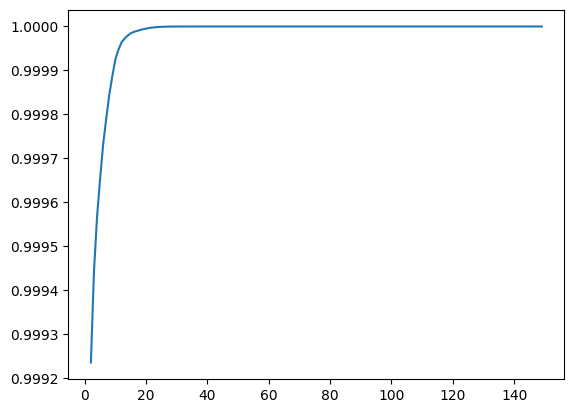

In [117]:

pd.Series(var_ratio).plot()

#### Kneed algorithm to find elbow point

<Figure size 500x500 with 0 Axes>

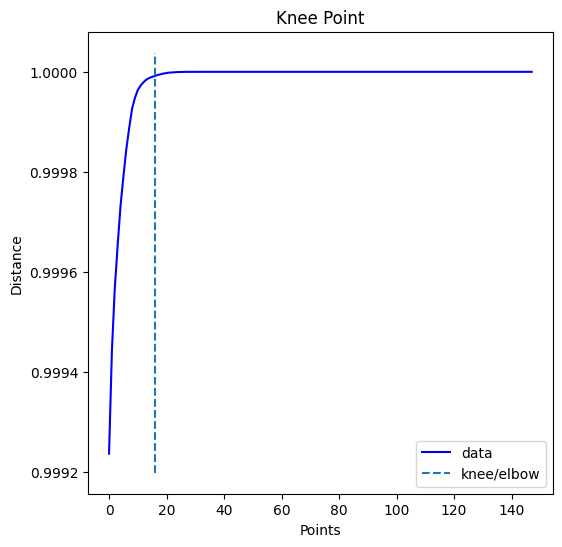

Knee Locator k = 18


In [118]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio = list(var_ratio.values())
components = list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5,5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel('Distance')
plt.show()
k = components[knee.knee]
print('Knee Locator k =',k)


In [119]:
# Reducing the dimensions of data
pca_final = PCA(n_components=18, random_state=42).fit(X_res)
reduced = pca_final.fit_transform(X_pca)

In [120]:
# Resampling the minority class. strategy can be changed as required
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# Fit model to generate data
X_res, y_res = smt.fit_resample(reduced, y)

In [121]:
# Training models
report_pca = evaluate_models(X_res, y_res, models)

Random Forest
Model Performance for Training set
- Accuracy: 0.9986
- F1 Score: 0.9986
- Precision: 1.0000
- Recall: 0.9972
- ROC AUC Score: 0.9986
- Cost: 38510
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9819
- F1 Score: 0.9821
- Precision: 0.9742
- Recall: 0.9902
- ROC AUC Score: 0.9819
- Cost: 36340


Gradient Boosting
Model Performance for Training set
- Accuracy: 0.9421
- F1 Score: 0.9419
- Precision: 0.9440
- Recall: 0.9398
- ROC AUC Score: 0.9421
- Cost: 856570
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9372
- F1 Score: 0.9373
- Precision: 0.9385
- Recall: 0.9361
- ROC AUC Score: 0.9372
- Cost: 228300


AdaBoosting
Model Performance for Training set
- Accuracy: 0.9209
- F1 Score: 0.9206
- Precision: 0.9233
- Recall: 0.9179
- ROC AUC Score: 0.9209
- Cost: 1168790
--------------------------------
Model Performance for Testing set
- Accuracy: 0.9179
- F1 Score: 0.9178
- Precision: 0.9219
- Recall: 0.9137
- 

#### Report for PCA and mean imputed data

In [122]:
report_pca

,Model Name,Cost,Accuracy
0,Random Forest,36340,0.981904
7,XGBoost Classifier,59980,0.977541
4,Decision Tree Classifier,72160,0.974537
8,Catboost Classifier,80330,0.972177
6,K- Neighbors Classifier,88280,0.960875
1,Gradient Boosting,228300,0.937200
2,AdaBoosting,307930,0.917889
3,Logistic Regression,711160,0.872613
5,Support Vector Classifier,1610500,0.759102


#### Final Model

In [126]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ['Model','Imputation_method', 'Total_cost']
pt.add_row(['XGBClassifier','Simple Imputer - Mean','2860'])
pt.add_row(['XGBClassifier','Simple Imputer-Constant','2890'])
pt.add_row(['XGBClassifier','KNN-Imputer','4430'])
pt.add_row(['XGBClassifier','Mice','6490'])
pt.add_row(['XGBClassifier','Median','6570'])
pt.add_row(['Random Forest','PCA','36340'])
print(pt)

+---------------+-------------------------+------------+
|     Model     |    Imputation_method    | Total_cost |
+---------------+-------------------------+------------+
| XGBClassifier |  Simple Imputer - Mean  |    2860    |
| XGBClassifier | Simple Imputer-Constant |    2890    |
| XGBClassifier |       KNN-Imputer       |    4430    |
| XGBClassifier |           Mice          |    6490    |
| XGBClassifier |          Median         |    6570    |
| Random Forest |           PCA           |   36340    |
+---------------+-------------------------+------------+


- from final report we can see than XGBClassifier with Simple Imputer with strategy mean has performed best with cost of 2860

#### Fitting final model and get reports

In [127]:
final_model = XGBClassifier()

# Resampling minority class. strategy can be changed as required
smt = SMOTETomek(random_state = 42, sampling_strategy='minority',n_jobs=-1)

# Fit model to generate data
X_res, y_res = smt.fit_resample(X_mean, y)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [129]:
print('Final XGBoost Classifier Accuracy Score (Train): ', final_model.score(X_train,y_train))
print('Final XGBoost Classifier Accuracy Score (Test): ', accuracy_score(y_pred, y_test))

Final XGBoost Classifier Accuracy Score (Train):  0.9999821810406272
Final XGBoost Classifier Accuracy Score (Test):  0.9970776906628653


In [130]:
print('Final XGBoost Classifier Cost Metric(Test) :', total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 2860


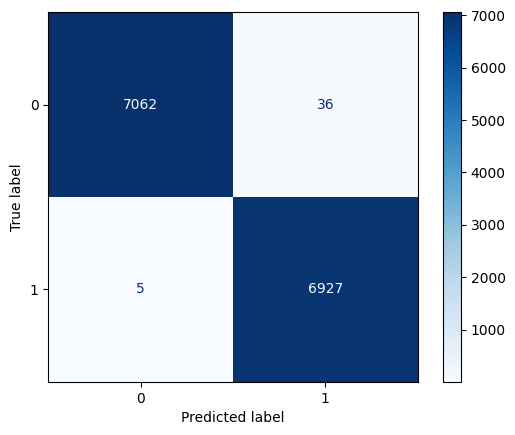

In [140]:
# from sklearn.metrics import plot_confusion_matrix

# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test,cmap='Blues', values_format = 'd')

##### The best model is XGBoost Classifier with 99.7% accuracy and cost of 2860